# Bayesian Optimization of Hyperparameters
*Vincent Dutordoir, Joachim van der Herten*

## Introduction

The paper *Practical Bayesian Optimization of Machine Learning algorithms* by Snoek et al. 2012 describes the 
use of Bayesian optimization for hyperparameter optimization. In this paper, the (at the time) state-of-the-art test error for convolutional neural networks on the CIFAR-10 dataset was improved significantly by optimizing the parameters of the training process with Bayesian optimization.

In this notebook we demonstrate the principle by optimizing the starting point of the maximum likelihood estimation of a GP. Note that we use a GP to optimize the initial hyperparameter values of another GP. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# Loading airline data
import numpy as np      
data = np.load('airline.npz')
X_train, Y_train = data['X_train'], data['Y_train']
D = Y_train.shape[1];

## Data set

The data to illustrate hyperparameter optimization is the well-known airline passenger volume data. It is a one-dimensional time series of the passenger volumes of airlines over time. We wish to use it to make forecasts. Plotting the data below, it is clear that the data contains a pattern.

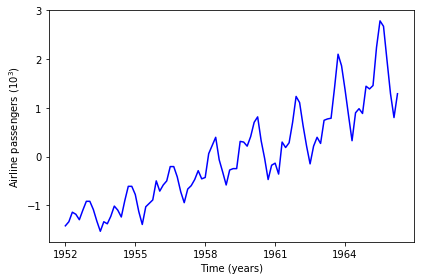

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Airline passengers ($10^3$)')
ax.plot(X_train.flatten(),Y_train.flatten(), c='b')
ax.set_xticklabels([1949, 1952, 1955, 1958, 1961, 1964])
plt.tight_layout()

## Modeling

To forecast this timeseries, we will pick up its pattern using a Spectral Mixture kernel (Wilson et al, 2013). Essentially, this kernel is a sum of $Q$ products of Cosine and RBF kernels. For this one-dimensional problem each term of the sum has 4 hyperparameters. To account for the upward trend, we also add a Linear and a Bias kernel.

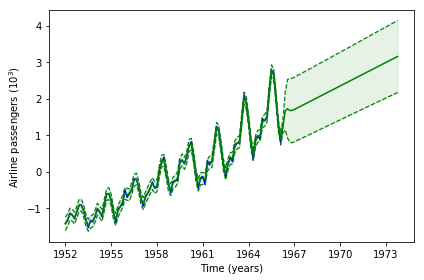

In [3]:
from gpflow.kernels import RBF, Cosine, Linear, Bias, Matern52
from gpflow import transforms
from gpflow.gpr import GPR

Q = 10 # nr of terms in the sum
max_iters = 1000

# Trains a model with a spectral mixture kernel, given an ndarray of 2Q frequencies and lengthscales
def create_model(hypers):
    f = np.clip(hypers[:Q], 0, 5)
    weights = np.ones(Q) / Q
    lengths = hypers[Q:]
    
    kterms = []
    for i in range(Q):
        rbf = RBF(D, lengthscales=lengths[i], variance=1./Q)
        rbf.lengthscales.transform = transforms.Exp()
        cos = Cosine(D, lengthscales=f[i])
        kterms.append(rbf * cos)
        
    k = np.sum(kterms) + Linear(D) + Bias(D)
    m = GPR(X_train, Y_train, kern=k)
    return m

X_test, X_complete = data['X_test'], data['X_complete']
def plotprediction(m):
    # Perform prediction
    mu, var = m.predict_f(X_complete)
    
    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Airline passengers ($10^3$)')
    ax.set_xticklabels([1949, 1952, 1955, 1958, 1961, 1964, 1967, 1970, 1973])
    ax.plot(X_train.flatten(),Y_train.flatten(), c='b')
    ax.plot(X_complete.flatten(), mu.flatten(), c='g')
    lower = mu - 2*np.sqrt(var)
    upper = mu + 2*np.sqrt(var)
    ax.plot(X_complete, upper, 'g--', X_complete, lower, 'g--', lw=1.2)
    ax.fill_between(X_complete.flatten(), lower.flatten(), upper.flatten(),
                    color='g', alpha=.1)
    plt.tight_layout()

m = create_model(np.ones((2*Q,)))
m.optimize(maxiter=max_iters)
plotprediction(m)

In total, a lot of hyperparameters must be optimized. Furthermore, the optimization surface of the spectral mixture is highly multimodal. Starting from the default hyperparameter values the optimized GP is able to pick up the linear trend, and the RBF kernels perform local interpolation. However, the kernel is not able to extrapolate away from the data. In sum, with this starting point, the likelihood optimization ends in a local minimum.

## Hyperparameter optimization

This issue is a known problem of the spectram mixture kernel, and several recommendations exist on how to improve the starting point. Here, we will use GPflowOpt to optimize the initial values for the lengthscales of the RBF and the Cosine kernel (i.e., the frequencies of the latter kernel). The other hyperparameters (rbf and cosine variances, likelihood variances and the linear and bias terms) are kept at their defaults and will be optimized by the standard likelihood optimization.

First, we setup the objective function accepting proposed starting points. The objective function returns the negative log likelihood, obtained by optimizing the hyperparameters from the given starting point. Then, we setup the 20D optimization domain for the frequencies and lengthscales.

In [4]:
from gpflowopt.domain import ContinuousParameter
from gpflowopt.objective import batch_apply

# Objective function for our optimization
# Input: N x 2Q ndarray, output: N x 1.
# returns the negative log likelihood obtained by training with given frequencies and rbf lengthscales
# Applies some tricks for stability similar to GPy's jitchol
@batch_apply
def objectivefx(freq):
    m = create_model(freq)        
    for i in [0] + [10**exponent for exponent in range(6,1,-1)]:
        try:
            mean_diag = np.mean(np.diag(m.kern.compute_K_symm(X_train)))
            m.likelihood.variance = 1 + mean_diag * i
            m.optimize(maxiter=max_iters)
            return -m.compute_log_likelihood()
        except:
            pass
    raise RuntimeError("Frequency combination failed indefinately.")

# Setting up optimization domain.
lower = [0.]*Q
upper = [5.]*int(Q)
df = np.sum([ContinuousParameter('freq{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])

lower = [1e-5]*Q
upper = [300]*int(Q)
dl = np.sum([ContinuousParameter('l{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])
domain = df + dl
domain

Name,Type,Values
freq0,Continuous,[ 0. 5.]
freq1,Continuous,[ 0. 5.]
freq2,Continuous,[ 0. 5.]
freq3,Continuous,[ 0. 5.]
freq4,Continuous,[ 0. 5.]
freq5,Continuous,[ 0. 5.]
freq6,Continuous,[ 0. 5.]
freq7,Continuous,[ 0. 5.]
freq8,Continuous,[ 0. 5.]
freq9,Continuous,[ 0. 5.]


High-dimensional Bayesian optimization is tricky, although the complexity of the problem is significantly reduced due to symmetry in the optimization domain (interchanging frequencies does not make a difference) and because we still optimize the likelihood given the starting point. Therefore, getting near a mode is sufficient. Furthermore we disable ARD of the kernel of the model approximating the objective function to avoid optimizing a lot of lengthscales with little data. We then use EI to pick new candidate starting points and evaluate our objective.

In [5]:
from gpflowopt.design import LatinHyperCube
from gpflowopt.acquisition import ExpectedImprovement
from gpflowopt import optim, BayesianOptimizer
design = LatinHyperCube(6, domain)
X = design.generate()

Y = objectivefx(X)
m = GPR(X, Y, kern=Matern52(domain.size, ARD=False))
ei = ExpectedImprovement(m)
opt = optim.StagedOptimizer([optim.MCOptimizer(domain, 5000), optim.SciPyOptimizer(domain)])
optimizer = BayesianOptimizer(domain, ei, optimizer=opt)
with optimizer.silent():
    result = optimizer.optimize(objectivefx, n_iter=24)

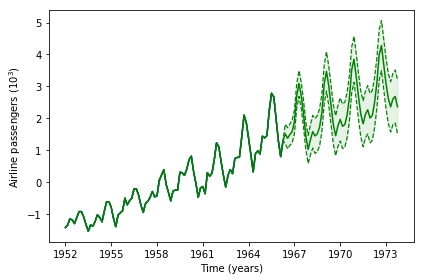

In [6]:
m = create_model(result.x[0,:])
m.optimize()
plotprediction(m)

Clearly, the optimization point identified with BO is a lot better than the default values. We now obtain a proper forecasting. By inspecting the evolution of the best likelihood value obtained so far, we see the solution is identified quickly.

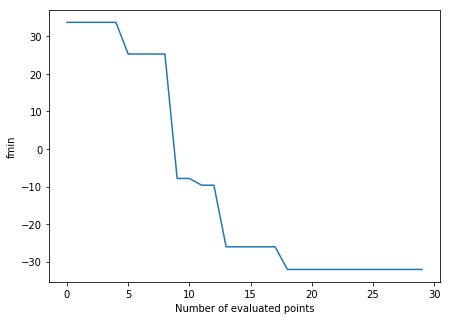

In [7]:
f, axes = plt.subplots(1, 1, figsize=(7, 5))
f = ei.data[1][:,0]
axes.plot(np.arange(0, ei.data[0].shape[0]), np.minimum.accumulate(f))
axes.set_ylabel('fmin')
axes.set_xlabel('Number of evaluated points');